Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

Epoch 4/30
75/75 [==============================] - 48s 638ms/step - loss: 0.0251 - accuracy: 0.9935 - val_loss: 0.0523 - val_accuracy: 0.9850
Epoch 5/30
75/75 [==============================] - 46s 609ms/step - loss: 0.0415 - accuracy: 0.9856 - val_loss: 0.0521 - val_accuracy: 0.9850
Epoch 6/30
75/75 [==============================] - 45s 605ms/step - loss: 0.0288 - accuracy: 0.9922 - val_loss: 0.0628 - val_accuracy: 0.9817
Epoch 7/30
75/75 [==============================] - 47s 620ms/step - loss: 0.0314 - accuracy: 0.9919 - val_loss: 0.0510 - val_accuracy: 0.9850
Epoch 8/30
75/75 [==============================] - 47s 620ms/step - loss: 0.0219 - accuracy: 0.9937 - val_loss: 0.0442 - val_accuracy: 0.9850
Epoch 9/30
75/75 [==============================] - 46s 619ms/step - loss: 0.0271 - accuracy: 0.9887 - val_loss: 0.0578 - val_accuracy: 0.9833
Epoch 10/30
75/75 [==============================] - 52s 698ms/step - loss: 0.0322 - accuracy: 0.9902 - val_loss: 0.0664 - val_accuracy: 0.981

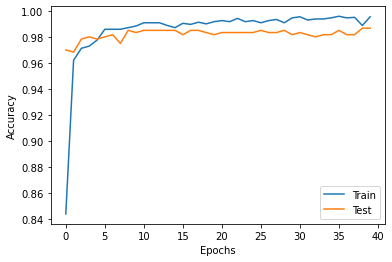

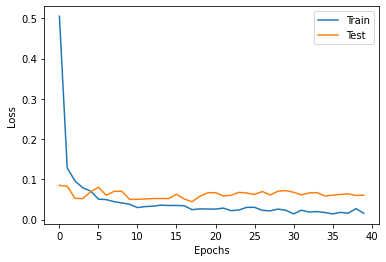

<AxesSubplot:>

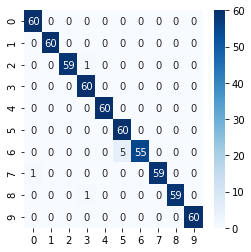

In [1]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/CMATERdb 3.4.1_Telugu_Numeral/Numerals/'
nb_train_samples = 2400
nb_validation_samples = 600
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 30
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned30

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=13)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=13)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [2]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9874425415937843
recall_score   :  0.9866666666666666
f1_score       :  0.9866653749663952
accuracy_score :  0.9866666666666667

Best accuracy  :  0.9866666793823242


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

Epoch 4/30
75/75 [==============================] - 56s 751ms/step - loss: 0.0268 - accuracy: 0.9899 - val_loss: 0.0659 - val_accuracy: 0.9850
Epoch 5/30
75/75 [==============================] - 52s 687ms/step - loss: 0.0487 - accuracy: 0.9834 - val_loss: 0.0655 - val_accuracy: 0.9850
Epoch 6/30
75/75 [==============================] - 54s 712ms/step - loss: 0.0311 - accuracy: 0.9886 - val_loss: 0.0649 - val_accuracy: 0.9850
Epoch 7/30
75/75 [==============================] - 52s 692ms/step - loss: 0.0267 - accuracy: 0.9912 - val_loss: 0.0637 - val_accuracy: 0.9800
Epoch 8/30
75/75 [==============================] - 56s 750ms/step - loss: 0.0314 - accuracy: 0.9893 - val_loss: 0.0654 - val_accuracy: 0.9833
Epoch 9/30
75/75 [==============================] - 58s 774ms/step - loss: 0.0385 - accuracy: 0.9887 - val_loss: 0.0707 - val_accuracy: 0.9800
Epoch 10/30
75/75 [==============================] - 56s 741ms/step - loss: 0.0286 - accuracy: 0.9907 - val_loss: 0.0814 - val_accuracy: 0.978

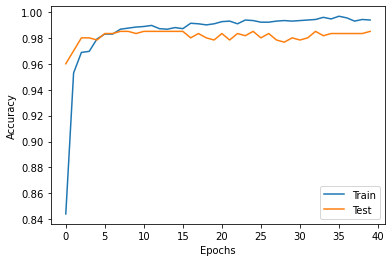

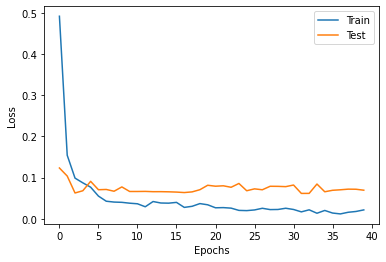

<AxesSubplot:>

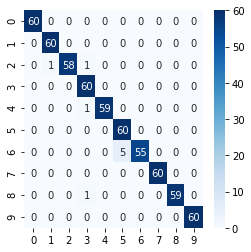

In [3]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/CMATERdb 3.4.1_Telugu_Numeral/Numerals/'
nb_train_samples = 2400
nb_validation_samples = 600
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 30
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned30

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=14)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=14)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [4]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9859064432834925
recall_score   :  0.985
f1_score       :  0.985011115718663
accuracy_score :  0.985

Best accuracy  :  0.9850000143051147


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

Epoch 4/30
75/75 [==============================] - 58s 772ms/step - loss: 0.0336 - accuracy: 0.9909 - val_loss: 0.0830 - val_accuracy: 0.9800
Epoch 5/30
75/75 [==============================] - 55s 737ms/step - loss: 0.0322 - accuracy: 0.9904 - val_loss: 0.0838 - val_accuracy: 0.9800
Epoch 6/30
75/75 [==============================] - 54s 716ms/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.0733 - val_accuracy: 0.9800
Epoch 7/30
75/75 [==============================] - 55s 734ms/step - loss: 0.0290 - accuracy: 0.9895 - val_loss: 0.0703 - val_accuracy: 0.9800
Epoch 8/30
75/75 [==============================] - 55s 726ms/step - loss: 0.0268 - accuracy: 0.9932 - val_loss: 0.0719 - val_accuracy: 0.9783
Epoch 9/30
75/75 [==============================] - 55s 738ms/step - loss: 0.0358 - accuracy: 0.9881 - val_loss: 0.0714 - val_accuracy: 0.9817
Epoch 10/30
75/75 [==============================] - 52s 689ms/step - loss: 0.0313 - accuracy: 0.9868 - val_loss: 0.0729 - val_accuracy: 0.980

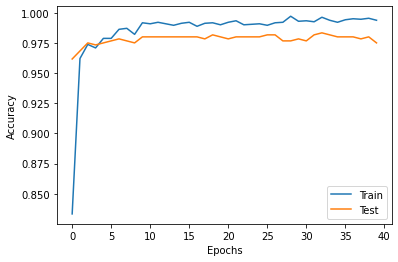

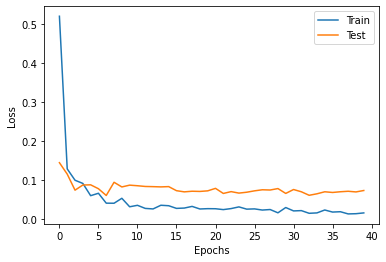

<AxesSubplot:>

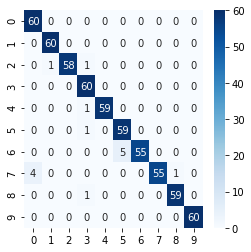

In [5]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/CMATERdb 3.4.1_Telugu_Numeral/Numerals/'
nb_train_samples = 2400
nb_validation_samples = 600
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 30
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned30

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=15)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=15)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [6]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9763814890710382
recall_score   :  0.975
f1_score       :  0.9749856609090923
accuracy_score :  0.975

Best accuracy  :  0.9833333492279053


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

Epoch 4/30
75/75 [==============================] - 52s 689ms/step - loss: 0.0375 - accuracy: 0.9870 - val_loss: 0.0597 - val_accuracy: 0.9817
Epoch 5/30
75/75 [==============================] - 54s 721ms/step - loss: 0.0266 - accuracy: 0.9946 - val_loss: 0.0598 - val_accuracy: 0.9817
Epoch 6/30
75/75 [==============================] - 56s 749ms/step - loss: 0.0382 - accuracy: 0.9899 - val_loss: 0.0488 - val_accuracy: 0.9833
Epoch 7/30
75/75 [==============================] - 50s 670ms/step - loss: 0.0381 - accuracy: 0.9883 - val_loss: 0.0547 - val_accuracy: 0.9783
Epoch 8/30
75/75 [==============================] - 49s 658ms/step - loss: 0.0325 - accuracy: 0.9902 - val_loss: 0.0554 - val_accuracy: 0.9833
Epoch 9/30
75/75 [==============================] - 49s 658ms/step - loss: 0.0240 - accuracy: 0.9944 - val_loss: 0.0592 - val_accuracy: 0.9833
Epoch 10/30
75/75 [==============================] - 50s 661ms/step - loss: 0.0253 - accuracy: 0.9929 - val_loss: 0.0582 - val_accuracy: 0.981

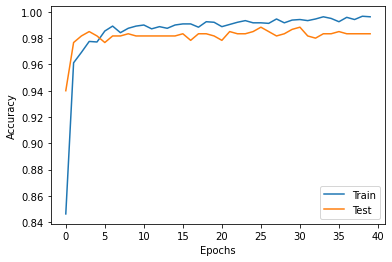

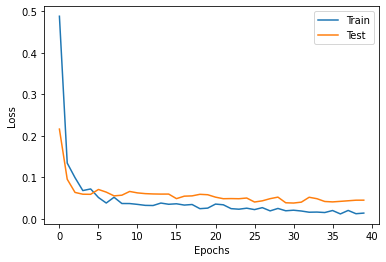

<AxesSubplot:>

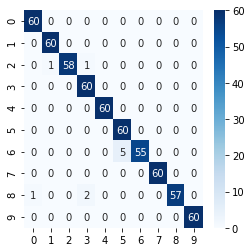

In [7]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/CMATERdb 3.4.1_Telugu_Numeral/Numerals/'
nb_train_samples = 2400
nb_validation_samples = 600
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 30
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned30

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=16)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=16)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [8]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9842670990211975
recall_score   :  0.9833333333333332
f1_score       :  0.9833012391424762
accuracy_score :  0.9833333333333333

Best accuracy  :  0.9883333444595337


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

Epoch 4/30
75/75 [==============================] - 49s 646ms/step - loss: 0.0335 - accuracy: 0.9878 - val_loss: 0.0627 - val_accuracy: 0.9833
Epoch 5/30
75/75 [==============================] - 49s 653ms/step - loss: 0.0352 - accuracy: 0.9907 - val_loss: 0.0642 - val_accuracy: 0.9833
Epoch 6/30
75/75 [==============================] - 51s 680ms/step - loss: 0.0355 - accuracy: 0.9875 - val_loss: 0.0565 - val_accuracy: 0.9800
Epoch 7/30
75/75 [==============================] - 49s 650ms/step - loss: 0.0328 - accuracy: 0.9911 - val_loss: 0.0596 - val_accuracy: 0.9817
Epoch 8/30
75/75 [==============================] - 50s 662ms/step - loss: 0.0299 - accuracy: 0.9900 - val_loss: 0.0627 - val_accuracy: 0.9833
Epoch 9/30
75/75 [==============================] - 49s 652ms/step - loss: 0.0336 - accuracy: 0.9920 - val_loss: 0.0652 - val_accuracy: 0.9833
Epoch 10/30
75/75 [==============================] - 50s 660ms/step - loss: 0.0343 - accuracy: 0.9859 - val_loss: 0.0604 - val_accuracy: 0.983

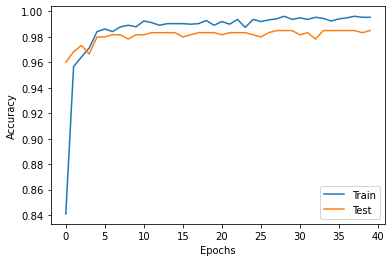

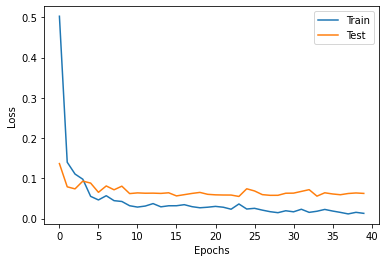

<AxesSubplot:>

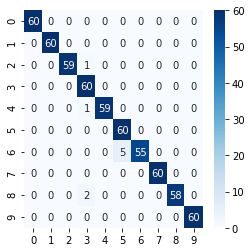

In [9]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/CMATERdb 3.4.1_Telugu_Numeral/Numerals/'
nb_train_samples = 2400
nb_validation_samples = 600
num_classes = 10

# learning params
epochs1 = 10
epochs2 = 30
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned30

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=17)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=17)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [10]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9860576923076924
recall_score   :  0.985
f1_score       :  0.9850507799382857
accuracy_score :  0.985

Best accuracy  :  0.9850000143051147
